In [ ]:
# use this notebook for rough drafts of stuff

# mainly being used right now to store our old stuff

# Imports

In [11]:
from LightPipes import *

from functions.colours          import *
from functions.measurement      import *
from functions.optical_modes    import *
from functions.plotting         import *
from functions.propagation      import *
from functions.turbulence       import *

import aotools
import cmath

pmap, imap, customColoursBGY, customColoursViridis = colours()

# Creating channel and propagation

## Create channel and prop OAM

In [23]:
#Simulation Parameters
size = 45*cm
N = 64

lensSize=size/4 # Radius

#Beam Parameters
wavelength = 633*nm
w0=6.67/1.5*cm # Radius

#Propagataion Params
z=5000*m
numberOfPhaseScreens=3

#Turbulence Parameters
C2_n = { # These can be toyed around with
    'WeakestTurb' : 1e-19,
    'WeakerTurb' : 1e-18,
    'WeakTurb' : 1e-17,
    'MidWeakerTurb' : 1.5e-17,
    'MidWeakTurb' : 1e-16,
    'MidTurb' : 1e-15,
    'StrongTurb' : 1e-14,
    'StrongerTurb' : 1e-13 
}

TurbStrength = 'MidTurb'

r0 = pow(0.423*pow(2*np.pi/wavelength,2)*C2_n[TurbStrength]*z/numberOfPhaseScreens,-3/5)
# Turbulence=2
# r0=size/Turbulence

phase_screen_seed=47

abbs=[aotools.turbulence.phasescreen.ft_sh_phase_screen(r0,N,size/N,100,0.001) for i in range(numberOfPhaseScreens)]

#Default Beam
F=Begin(size,wavelength,N)

In [ ]:
beams=[propChannel(OAM(F,w0,i),z,numberOfPhaseScreens,0) for i in progress(ell(4))]
errorBeams=[propChannel(OAM(F,w0,i),z,abbs) for i in progress(ell(4))]


plt.show(plotCrosstalk(crosstalk(beams,errorBeams)))
print(f'Error rate of {beamsError(beams,errorBeams)}')

plt.show(plot_beam(errorBeams,rows=1,aperature=size/3))
plt.show(plot_beam(beams,rows=1,aperature=size/3))

## propagate a single pixel with no turbulence

In [ ]:
intens = np.zeros((N, N))
intens[N//2][N//2] = 1

#FieldOut = propChannel(SubIntensity(FieldIn, intens), z, abbs)
#FieldOut = propChannel(CircAperture(SubIntensity(FieldIn, intens),FieldIn.siz/2), z, abbs)
F2 = [CircAperture(propChannel(CircAperture(SubPhase(SubIntensity(F, intens),np.zeros((N,N))),R=lensSize), dist),R=lensSize) for dist in [1,1000,2000,3000,4000,5000]]

plt.show(plot_beam(F2,aperature=lensSize,dpi=3*N))


## propagate all pixels

In [22]:
abbs = gen_turb_channel(size, N, wavelength, z, C2_n[TurbStrength], num_phase_screens=3, phase_screen_seed=47, shift=1, abbs=[])
if __name__ == "__main__":
    FieldsOut, endFields = parallelpropagatePixels(size, wavelength, N, z, lensSize, abbs)
    print(f"Successfully processed {len(endFields)} pixels.")

Using 10 threads to propagate beams simulataneously...


Propagating invidual Pixels: 100%|██████████| 4096/4096 [00:49<00:00, 83.46it/s] 


Successfully processed 4096 pixels.


# Infinite Phase Screens

## General definitions

In [ ]:
#Simulation Parameters
size = 45*cm
N = 192

## Kolmogerov statistics

In [ ]:
from aotools.turbulence.infinitephasescreen import PhaseScreenKolmogorov
# Note that i set L0=75, if you try L0=100 you get some error at least for N=64. For N=64 we need L0<90 from my testing
# N=128 we need L0<41. Actually using L0=40 makes it look totally fucked lol. Even L0=30 is messed. Using L0=25 is nice... looks like using a small L0 with more resolution is the fix
L0 = N/2 * size / N * 50
inf_ps = PhaseScreenKolmogorov(nx_size=N, pixel_scale=size/N, r0=r0, L0=L0,random_seed=phase_screen_seed, stencil_length_factor=4)
inf_ps1 = inf_ps.scrn
inf_ps2 = PhaseScreenKolmogorov.get_new_row(inf_ps)

for i in range(0,int(N*100)):
    inf_ps3 = PhaseScreenKolmogorov.add_row(inf_ps)

In [ ]:
# plt.imshow(wrap_to_pi(inf_ps3), cmap=pmap, vmin=-np.pi, vmax=np.pi)
# plt.colorbar()

In [ ]:
# plt.imshow(wrap_to_pi(inf_ps3), cmap=pmap, vmin=-np.pi, vmax=np.pi)
# plt.colorbar()

## Von Karman statistics

In [ ]:
# Infinite phase screens but with Von Karmon statistics

from aotools.turbulence.infinitephasescreen import PhaseScreenVonKarman
L0 = N/2 * size / N * 50 # outer scale
inf_ps = PhaseScreenVonKarman(nx_size=N, pixel_scale=size/N, r0=r0, L0=L0, random_seed=phase_screen_seed)
inf_ps1 = inf_ps.scrn.copy()

# for i in range(0,int(N*10)):
#     inf_ps2 = PhaseScreenVonKarman.add_row(inf_ps)

# print(inf_ps.scrn)
# print('\n\n\n')
inf_ps.scrn[:] = np.flipud(inf_ps.scrn)
# print(inf_ps.scrn)
for _ in range(0, 20):
    inf_ps4 = PhaseScreenVonKarman.add_row(inf_ps)
inf_ps4 = np.flipud(inf_ps4)

In [ ]:
# plt.imshow(wrap_to_pi(inf_ps1), cmap=pmap, vmin=-np.pi, vmax=np.pi)
# plt.colorbar()

In [ ]:
# plt.imshow(wrap_to_pi(inf_ps2), cmap=pmap, vmin=-np.pi, vmax=np.pi)
# plt.colorbar()

# Saving images

## Saving images of gaussian beam after propagating

In [ ]:
# Create folder first
os.makedirs("images/gaussian_prop", exist_ok=True)

#Default Beam
F=Begin(size,wavelength,N)

#Turbulence Parameters
C2_n = { # These can be toyed around with
    'WeakestTurb' : 1e-19,
    'WeakerTurb' : 1e-18,
    'WeakTurb' : 1e-17,
    'MidWeakerTurb' : 1.5e-17,
    'MidWeakTurb' : 1e-16,
    'MidTurb' : 1e-15,
    'StrongTurb' : 1e-14,
    'StrongerTurb' : 1e-13 
}
TurbStrength = 'MidWeakTurb'
numberOfPhaseScreens=8

r0 = pow(0.423*pow(2*np.pi/wavelength,2)*3*C2_n[TurbStrength]*z/numberOfPhaseScreens,-3/5)

L0 = N/2 * size / N * 50 # outer scale

# Create phase screens
abbs=[PhaseScreenVonKarman(nx_size=N, pixel_scale=size/N, r0=r0, L0=L0,random_seed=phase_screen_seed+i) for i in range(numberOfPhaseScreens)]

In [ ]:
# Plot phase screens
ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
fig = plt.figure(1, figsize=(9,3), constrained_layout=True)
axes=[]
images=[]
for j in range(numberOfPhaseScreens):
    ax = fig.add_subplot(1,numberOfPhaseScreens,j+1)
    im = ax.imshow(wrap_to_pi(abbs[j].scrn), cmap=pmap, vmin=-np.pi, vmax=np.pi)
    axes.append(ax)
    images.append(im)
cbar = fig.colorbar(im)
cbar.set_ticks(ticks)
cbar.set_ticklabels([r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"])

In [ ]:
errorBeams=[]
numberOfFluctuations = 600
shift = 1 # How many rows to add with every fluctuation
ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]


abbs=[PhaseScreenVonKarman(nx_size=N, pixel_scale=size/N, r0=r0, L0=L0,random_seed=phase_screen_seed+i) for i in range(numberOfPhaseScreens)]

for i in progress(range(numberOfFluctuations+1)):
    for j,screen in enumerate(abbs):
        extend_phase_screen(screen,direction=j,num_steps=shift)
    # Plot phase screens
    # fig = plt.figure(i+1, figsize=(9,3), constrained_layout=True)
    # axes=[]
    # images=[]
    # for j in range(numberOfPhaseScreens):
    #     ax = fig.add_subplot(1,numberOfPhaseScreens,j+1)
    #     im = ax.imshow(wrap_to_pi(abbs[j].scrn), cmap=pmap, vmin=-np.pi, vmax=np.pi)
    #     axes.append(ax)
    #     images.append(im)
    # cbar = fig.colorbar(im)
    # cbar.set_ticks(ticks)
    # cbar.set_ticklabels([r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"])
    errorBeams.append([propChannel(OAM(F,w0/1.2,l),z,abbs)for l in [-2,-1,0,1,2]])

In [ ]:
os.makedirs("images/OAM_prop", exist_ok=True)

for i,Beam in progress(enumerate(errorBeams)):
    plot_beam(Beam,phase=False)
    plt.savefig(
        f"images/OAM_prop/step_{i:04d}.png",
        dpi=300,
        bbox_inches="tight",
        pad_inches=0
    )
    #plt.show()
    plt.close()

In [ ]:
create__web_movie("images/OAM_prop", "vids/OAM_prop.webm", fps=30)

# Calculate Eigenmodes

## Calculate eigenvalues and eigenvectors

In [7]:
transferMatrix=endFields

transferMatrixT=endFields.T

transferMatrixH=endFields.T.conj()

transferMatrixHermitian=transferMatrixH@transferMatrix

eigVals,eigVecs=np.linalg.eig(transferMatrixT)

#Get the absolute values and phases of the eigenvalues
eigMags=abs(eigVals)

In [8]:
# Sort the Eigenvalues by the magnitudes
sort_indices = np.argsort(eigMags)[::-1]
eigMags = eigMags[sort_indices]
eigVals = eigVals[sort_indices]
eigVecs = eigVecs[:, sort_indices]

## Plot Eigenvalues

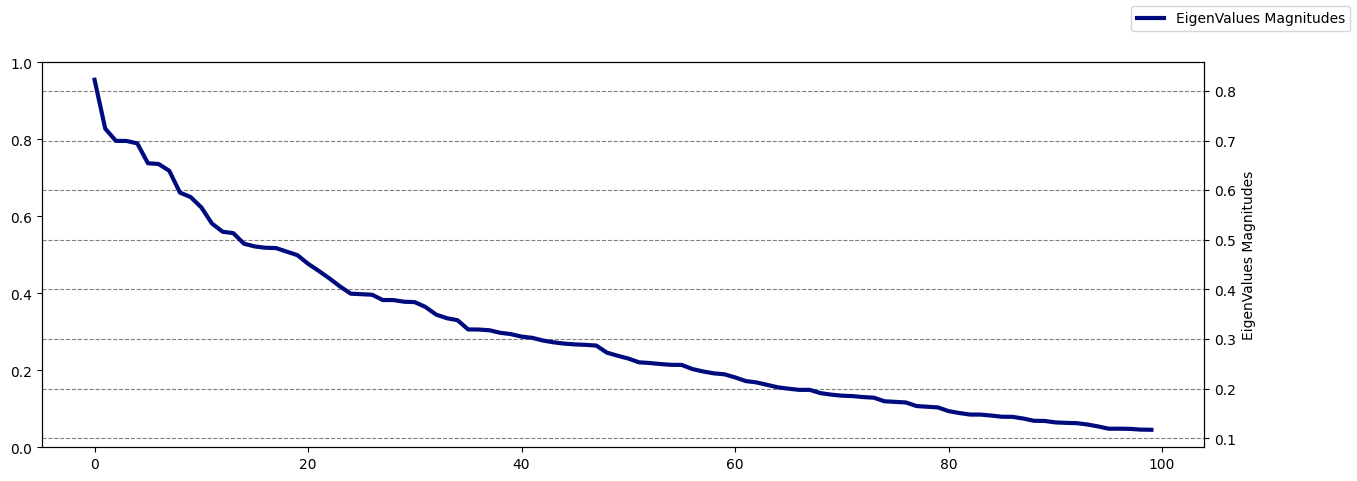

In [9]:
# Plot the eigenvalues

fig, ax1 = plt.subplots()
fig.set_size_inches(15,5)
x=range(0,len(eigMags))
ax2 = ax1.twinx()
ax2.yaxis.grid(True)
ax2.grid(visible=True,which='major',axis='both',color='gray',linestyle='--')
#ax1.set_ylabel('EigenValues Phases')
ax2.set_ylabel('EigenValues Magnitudes')

ax2.plot(x[:100],eigMags[:100],label='EigenValues Magnitudes',color=customColoursBGY[0],linewidth=3)

fig.legend()
plt.show()

## Create optical modes

In [12]:
#Making Eigenvector optical modes
F=Begin(size,wavelength,N)
eigenBeams=[]
for i in progress(range(100)):
    mode=eigVecs[:,i]
    eigenInt=[abs(val)**2 for val in mode]
    eigenInt=np.pad(np.array(eigenInt).reshape((N,N)),pad_width=int(0), mode='constant', constant_values=0)
    eigenPhase=[cmath.phase(val) for val in mode]
    eigenPhase=np.pad(np.array(eigenPhase).reshape((N,N)),pad_width=int(0), mode='constant', constant_values=0)
    F=SubPhase(SubIntensity(F,eigenInt),eigenPhase)
    eigenBeams.append(F)

eigenBeamPropagated=[propChannel(beam,z,abbs) for beam in progress(eigenBeams)]


100%|██████████| 100/100 [00:00<00:00, 103.61it/s]


### Normalize phase for plotting

In [ ]:
############################
####
####
#### Need to normalize the phase on the propagated eigenmode to be able 
####    to display them next to one another and have consistent phase profiles.
####
############################

In [13]:
# Loop through eigenbeams and find position with max intensity and then find the phase there. Then find the difference in phase in the
# same position after propagating and subtract the entire array after propagating by this phase difference

for i, eigenBeam in enumerate(eigenBeams):
    intensity = Intensity(eigenBeam,1)
    max_pos = np.unravel_index(intensity.argmax(), intensity.shape)
    phase_diff = np.mod(Phase(eigenBeamPropagated[i]), 2*np.pi)[max_pos] - np.mod(Phase(eigenBeam), 2*np.pi)[max_pos]
    eigenBeamPropagated[i].field *= np.exp(1j * (-phase_diff)) # Subtract phase difference

## Plot optical modes

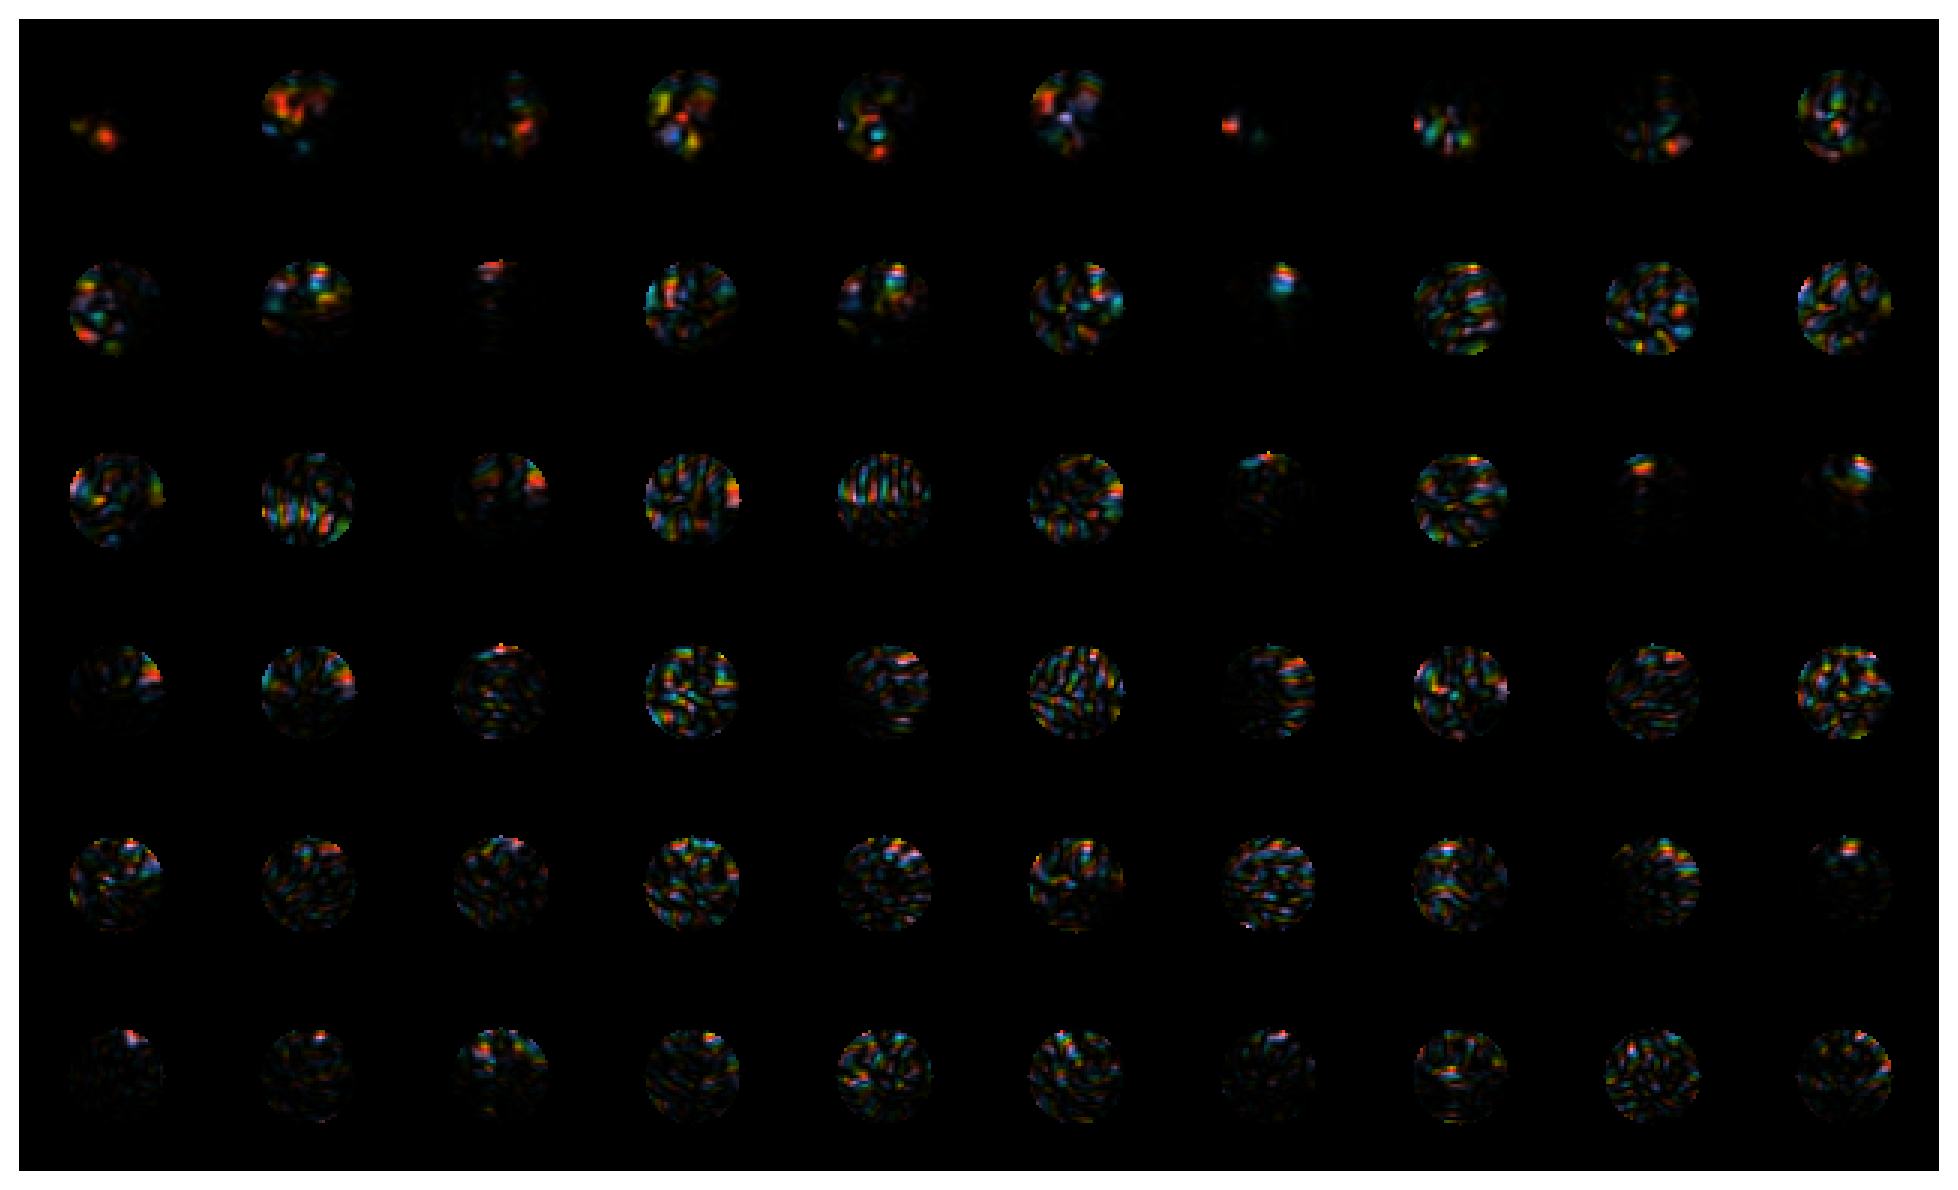

In [14]:
plot=plot_beam(eigenBeams[:60],rows=6,dpi=N*3)
plt.show();plt.close()

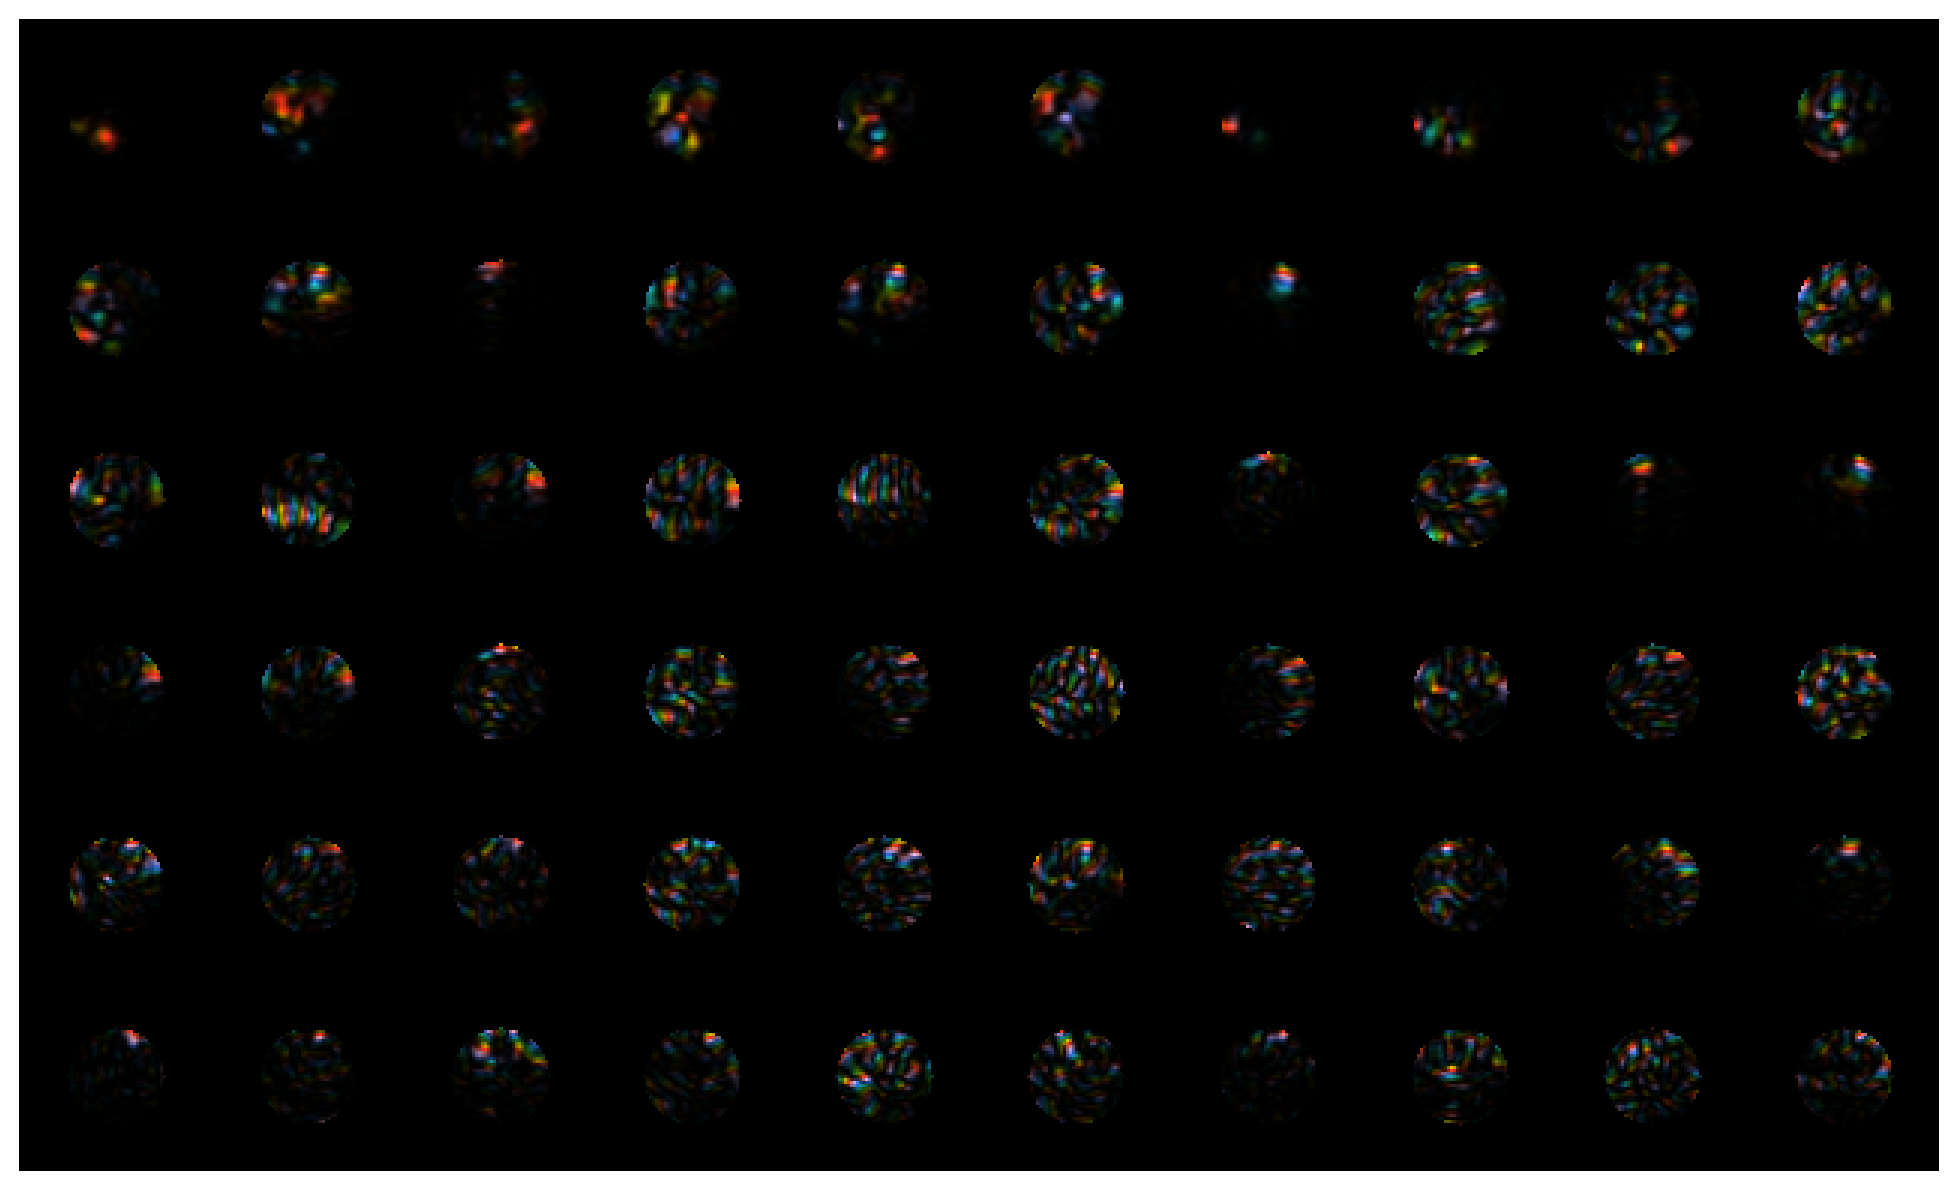

In [15]:
plot=plot_beam([CircAperture(beam,R=lensSize) for beam in eigenBeamPropagated[:60]],rows=6,dpi=N*3)
plt.show();plt.close()

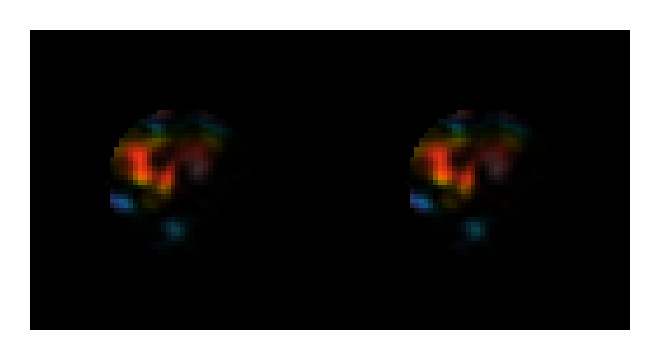

In [16]:
plt.show(plot_beam([eigenBeams[1],CircAperture(eigenBeamPropagated[1],R=lensSize)]))

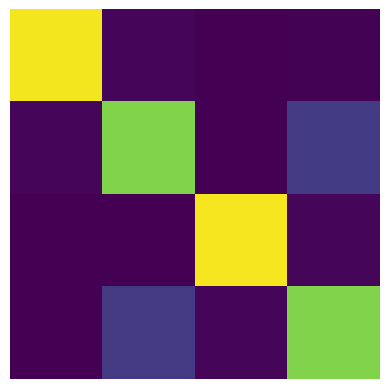

Error rate of 0.10201135060721833 when doing a measurement in the unpropagated Eigenmode basis


In [17]:
modeNumber=4

bestEigenBeams=eigenBeams[:modeNumber]
bestEigenBeamsPropagated=eigenBeamPropagated[:modeNumber]


plt.show(plotCrosstalk(crosstalk(bestEigenBeams,bestEigenBeamsPropagated)))
print(f'Error rate of {beamsError(bestEigenBeams,bestEigenBeamsPropagated)} when doing a measurement in the unpropagated Eigenmode basis')